# Task 3: Predictive Analysis


Consider the problem of predicting for each customer a label that defines if (s)he is a
high-spending customer, medium-spending customer or low-spending customer.

### 1) Define a customer profile that enables the above customer classification. 
Please, reason on the suitability of the customer profile, defined for the clustering
analysis. In case this profile is not suitable for the above prediction problem you
can also change the indicators.

In [1]:
%matplotlib inline
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* **Decision trees** are robust to outliers.
* **Random Forests** are not sensitive to outliers.
* The **neural network** is unaffected by the outliers impact when the percentage-outliers in the training data is lower than 15%.
* Decision **rules based** are also robust against outliers
* In **Gaussian Naive Bayes**, outliers will affect the shape of the Gaussian distribution and have the usual effects on the mean etc.
* **KNN** : If 'K' value is low, the model is susceptible to outliers. If 'K' value is high, the model is robust to outliers.
* **Standard SVM** is sensitive to outliers.

In [2]:
df = pd.read_csv(r'/content/drive/My Drive/DataMing/Basket.csv', index_col=0)
Cusdf = pd.read_csv(r'/content/drive/My Drive/DataMing/Cusdf.csv', index_col=0)

* I: the total number of items purchased by a customer during the period of
observation.
* Iu: the number of distinct items bought by a customer in the period of
observation.
* Imax: the maximum number of items purchased by a customer during a
shopping session
* E: the Shannon entropy on the purchasing behaviour of the customer

In [3]:
# new code for defining indicators
querySer = (df.loc[:,'BasketDate']<'2011-12-01') & (df.loc[:,'BasketDate'] > '2010-11-30')
df = df.loc[querySer,:]
ct = df[['CustomerID']].drop_duplicates()
# Generate new feature 'Amount'
df['Amount']= df['Sale']*df['Qta']
# Transform 'BasketDate'.
date_split=df['BasketDate'].astype('str').str.split(' ')
df['Date']=date_split.str[0]
# Parse the variable 'Date' from type 'str' to type 'datetime64[ns]'.
df.loc[:,'Date']=pd.to_datetime(df.loc[:,'Date'], format='%Y-%m-%d', errors='coerce')
Max_date = df.Date.max()
ct['LastDate'] = df.groupby('CustomerID')['Date'].transform('max')
ct['FirstDate'] = df.groupby('CustomerID')['Date'].transform('min')
# I: the total number of items purchased by a customer during the period of observation.
ct['I'] = round(df.groupby('CustomerID').Qta.transform('sum')/(pd.Series(ct['LastDate']-ct['FirstDate']).dt.days+1),2)
# Iu: the number of distinct items bought by a customer in the period of observation.
ct['Iu'] = df.groupby('CustomerID').ProdID.transform('nunique')
# Imax: the maximum number of items purchased by a customer during a shopping session
df['BasketQta'] = df.groupby('BasketID').Qta.transform('sum')
ct['Imax'] = df.groupby('CustomerID').BasketQta.transform('max')
# Generate new feature 'Frequency' - How often do they purchase?
Unique_purchase = df.drop_duplicates(subset=['BasketID'])
ct['Frequency'] = round(Unique_purchase.groupby('CustomerID').BasketID.transform('count')/(pd.Series(ct['LastDate']-ct['FirstDate']).dt.days+1),2)
# Generate new feature 'Monetary' - How much do they spend?
ct['Monetary'] = round(df.groupby('CustomerID').Amount.transform('sum')/(pd.Series(ct['LastDate']-ct['FirstDate']).dt.days+1),2)
# Generate new feature 'Weekday'.
df['Weekday'] = df.Date.dt.day_name()
# E: the Shannon entropy on the purchasing behaviour of the customer
ct['E'] = round(df.groupby('CustomerID')['Weekday'].transform(lambda x : scipy.stats.entropy(x.value_counts())),2)
ct.drop(columns=['CustomerID', 'LastDate', 'FirstDate'], axis=1,inplace=True)

In [4]:
# scaler_m = MinMaxScaler()
# ct.loc[:,:] = scaler_m.fit_transform(ct.values)
ct.head()

,I,Iu,Imax,Frequency,Monetary,E
25281,7.70,167,267,0.08,20.10,1.42
25301,3.58,104,126,0.07,13.20,1.53
25308,8.55,217,530,0.04,9.98,1.22
25351,70.00,66,70,1.00,141.04,0.00
25421,108.00,37,108,1.00,269.83,0.00


### 2) Compute the label for any customer. 
Note that, the class to be predicted must be nominal.

In [5]:
# divided 'Monetary' into 3 equal parts
m_labels=range(0,3,1)
m_quartiles = pd.qcut(ct['Monetary'],q=3,labels=m_labels)
ct = ct.assign(Lable_M=m_quartiles)
#drop the Monetary variable since we don't need it anymore 
ct.drop(columns=['Monetary'], axis=1,inplace=True)
ct.head()

,I,Iu,Imax,Frequency,E,Lable_M
25281,7.70,167,267,0.08,1.42,1
25301,3.58,104,126,0.07,1.53,1
25308,8.55,217,530,0.04,1.22,1
25351,70.00,66,70,1.00,0.00,2
25421,108.00,37,108,1.00,0.00,2


In [6]:
# low-spending customer
ct[ct['Lable_M']== 0].count()

I            1251
Iu           1251
Imax         1251
Frequency    1251
E            1251
Lable_M      1251
dtype: int64

In [7]:
 # medium-spending customer
 ct[ct['Lable_M']== 1].count()

I            1249
Iu           1249
Imax         1249
Frequency    1249
E            1249
Lable_M      1249
dtype: int64

In [8]:
# high-spending customer
ct[ct['Lable_M']== 2].count()

I            1250
Iu           1250
Imax         1250
Frequency    1250
E            1250
Lable_M      1250
dtype: int64

In [9]:
ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750 entries, 25281 to 538812
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   I          3750 non-null   float64 
 1   Iu         3750 non-null   int64   
 2   Imax       3750 non-null   int64   
 3   Frequency  3750 non-null   float64 
 4   E          3750 non-null   float64 
 5   Lable_M    3750 non-null   category
dtypes: category(1), float64(3), int64(2)
memory usage: 339.6 KB


### 3) perform the predictive analysis.
comparing the performance of different models, discussing the results, and discussing the possible preprocessing that they applied to the data for managing possible problems identified that can make the prediction hard. Note that the evaluation should be performed on both training and test set.


##### Preprocessing:

In [10]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = ct.pop('Lable_M')
train_set, test_set, train_label, test_label = train_test_split(ct, label, stratify =label, test_size=0.25)
len(train_set),len(test_set)

(2812, 938)

#### Classification with Naive Bayes

In [ ]:
# import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

# prediction on the train/test set
train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

In [ ]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_gnb))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_gnb))
print('Precision train set ', metrics.precision_score(train_label, train_pred_gnb, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_gnb, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_gnb, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_gnb, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_gnb, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_gnb))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_gnb))

Accuracy train set  0.8076102418207681
Accuracy test set  0.8102345415778252
Precision train set  0.8201981715460391
Precision test set  0.8191027496001541
Recall train set  0.8076102418207681
Recall test set  0.8102345415778252
F1 score train set  0.7995016282226528
F1 score test set  0.8019266423851228
Support train set  (array([0.69288079, 0.84065041, 0.92719919]), array([0.89232409, 0.55176094, 0.97865528]), array([0.78005592, 0.66623711, 0.95223261]), array([938, 937, 937]))
Support test set  (array([0.70618557, 0.84210526, 0.90909091]), array([0.87539936, 0.56410256, 0.99041534]), array([0.78174037, 0.6756238 , 0.94801223]), array([313, 312, 313]))


In [ ]:
# metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['low-spending customer', 'medium-spending customer', 'high-spending customer']))

In [ ]:
#compute the performance of the model
report_scores(train_label,train_pred_gnb)

                          precision    recall  f1-score   support

   low-spending customer       0.69      0.89      0.78       938
medium-spending customer       0.84      0.55      0.67       937
  high-spending customer       0.93      0.98      0.95       937

                accuracy                           0.81      2812
               macro avg       0.82      0.81      0.80      2812
            weighted avg       0.82      0.81      0.80      2812



In [ ]:
report_scores(test_label,test_pred_gnb)

                          precision    recall  f1-score   support

   low-spending customer       0.71      0.88      0.78       313
medium-spending customer       0.84      0.56      0.68       312
  high-spending customer       0.91      0.99      0.95       313

                accuracy                           0.81       938
               macro avg       0.82      0.81      0.80       938
            weighted avg       0.82      0.81      0.80       938



#### Classfication with decision tree :

* Grid search for hyper-parameters of decision tree:

1. 'criterion' : ['gini', 'entropy']
2. 'max_depth' : [2, 5, 10, 15, None]
3. 'min_samples_split' : [2, 5, 10, 20]
4. 'min_samples_leaf': [2, 5, 10, 20]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'criterion' : ['gini', 'entropy'],
      'max_depth' : [2, 5, 10, 15, None],
      'min_samples_split' : [2, 5, 10, 20],
      'min_samples_leaf': [2, 5, 10, 20]}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(),params,verbose=1,cv=5)
grid_search_cv.fit(train_set, train_label)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    7.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [ ]:
grid_search_cv.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [ ]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

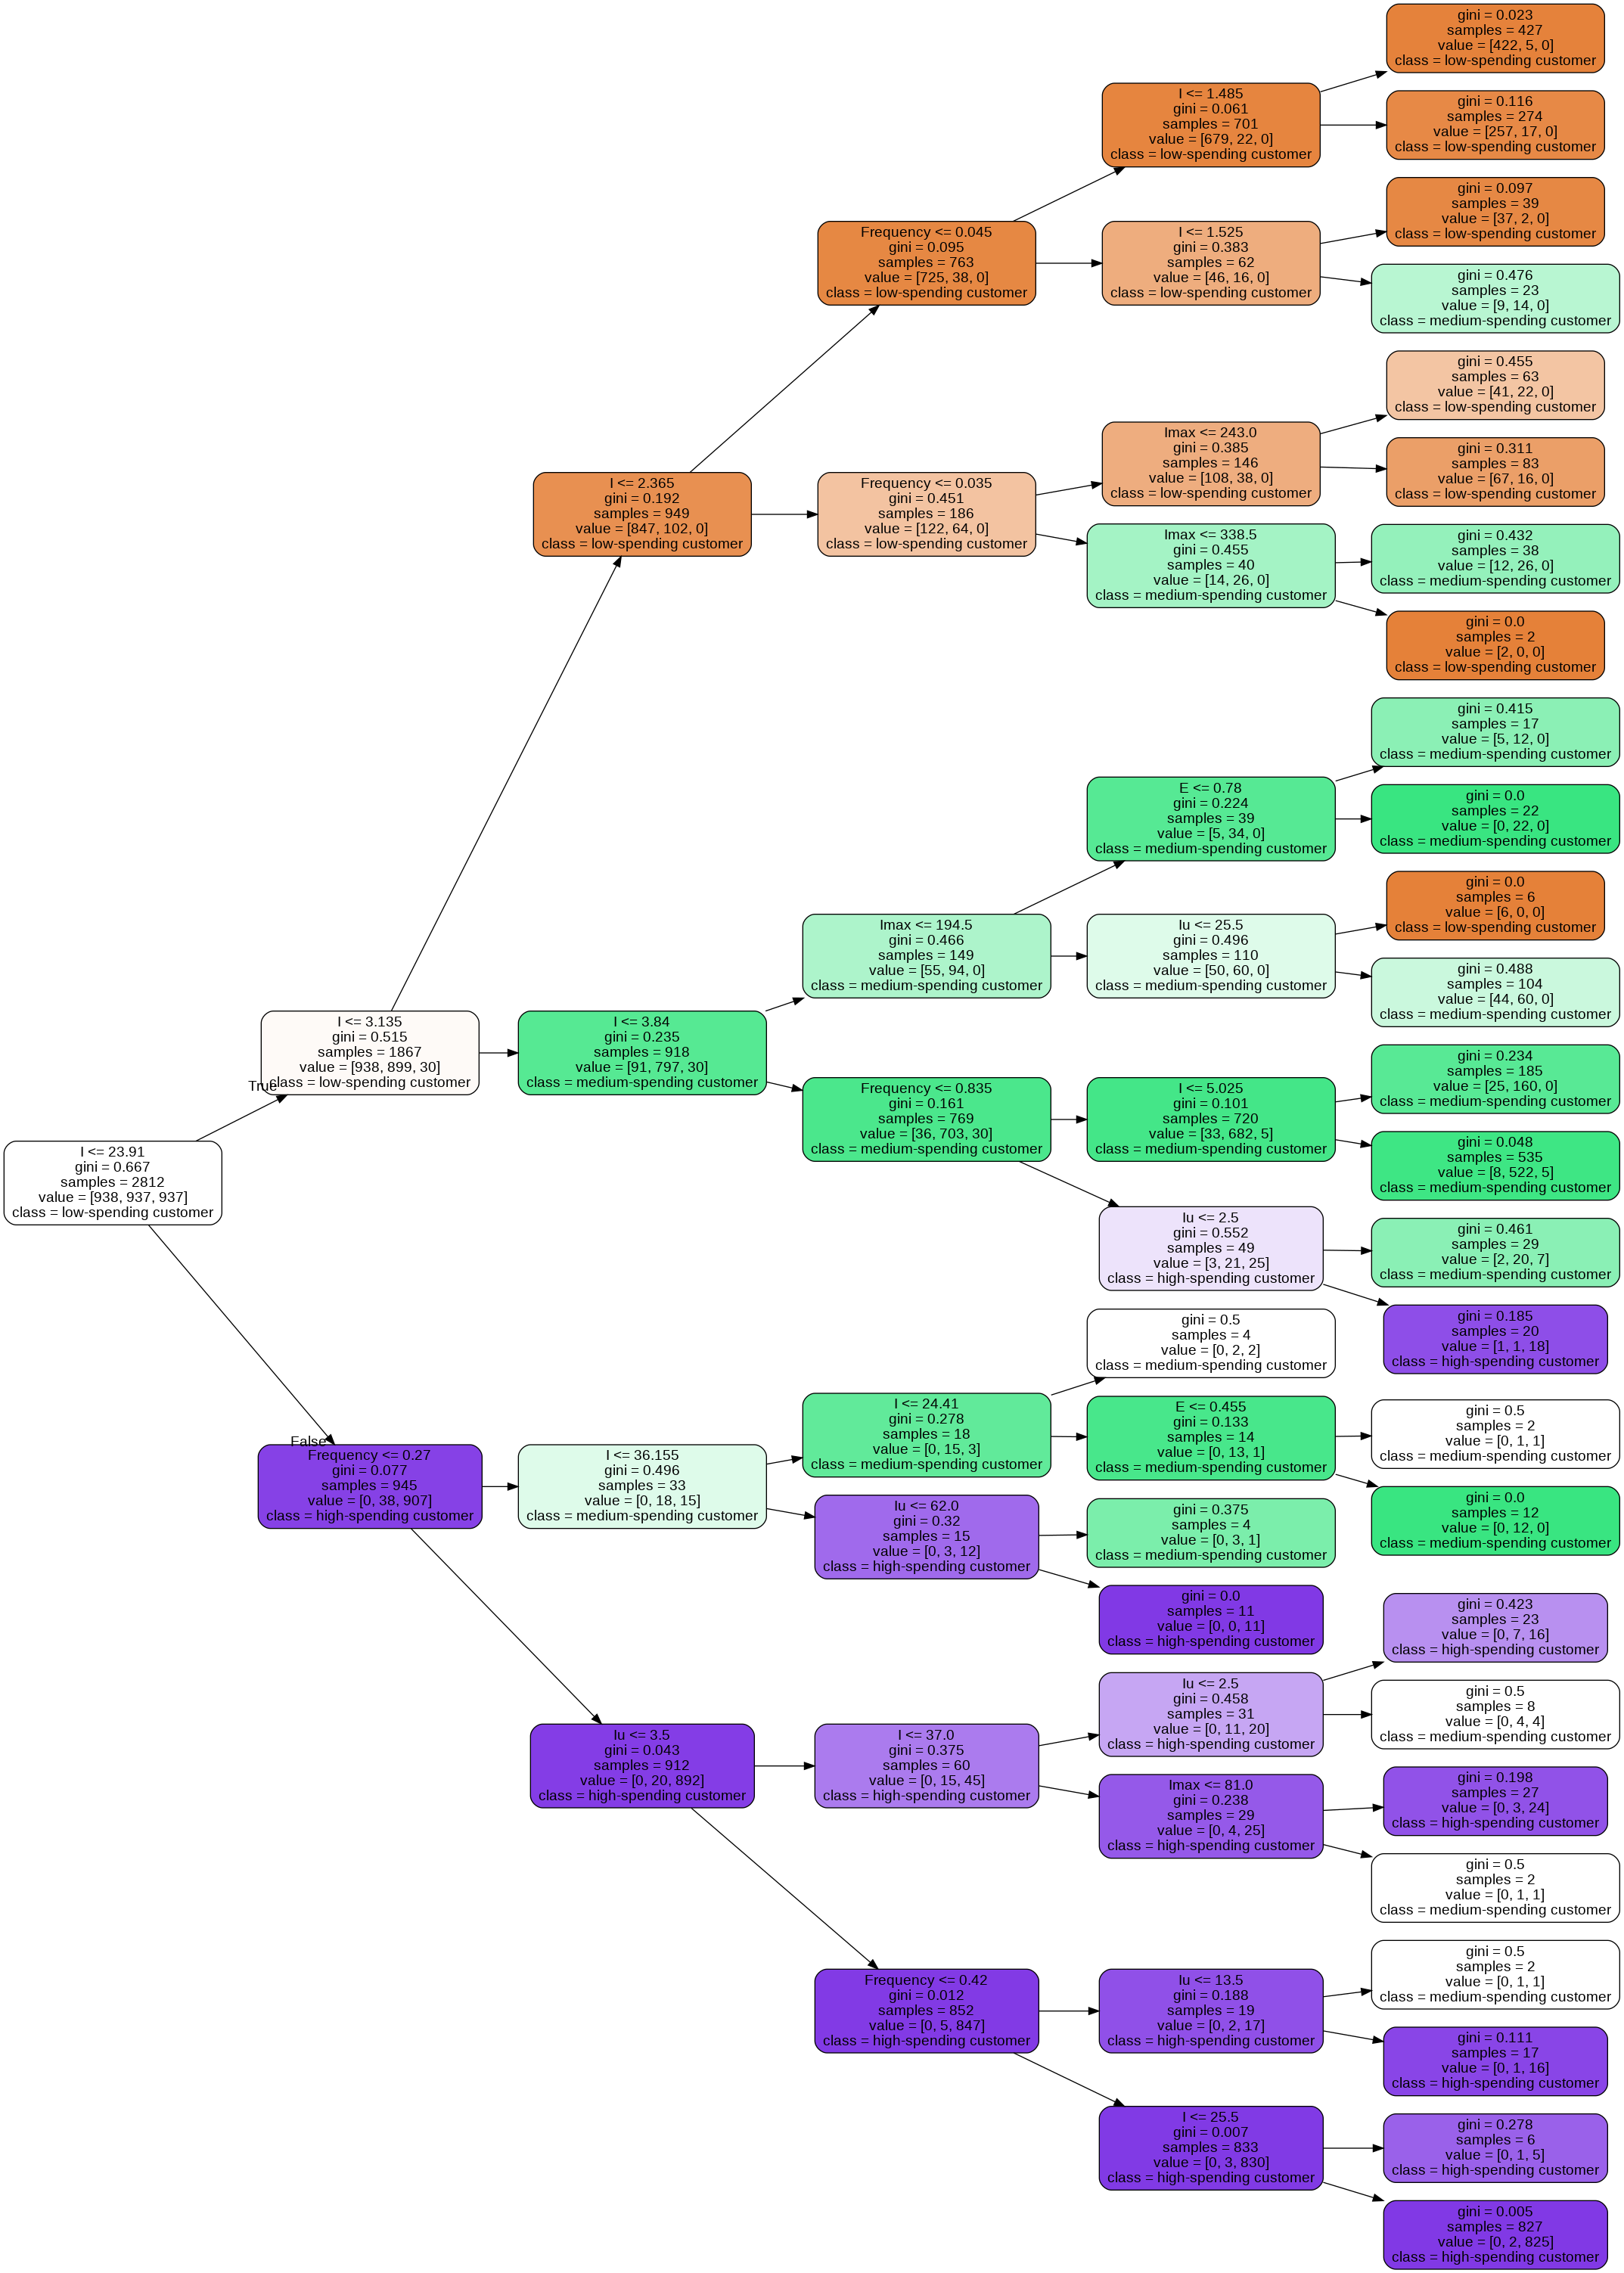

In [27]:
# visualize the actual decision tree obtained 
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(grid_search_cv.best_estimator_,
               out_file=None,
               feature_names=list(train_set.columns),  
               class_names=['low-spending customer', 'medium-spending customer', 'high-spending customer'],  
               filled=True,
               rotate=True,
               rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

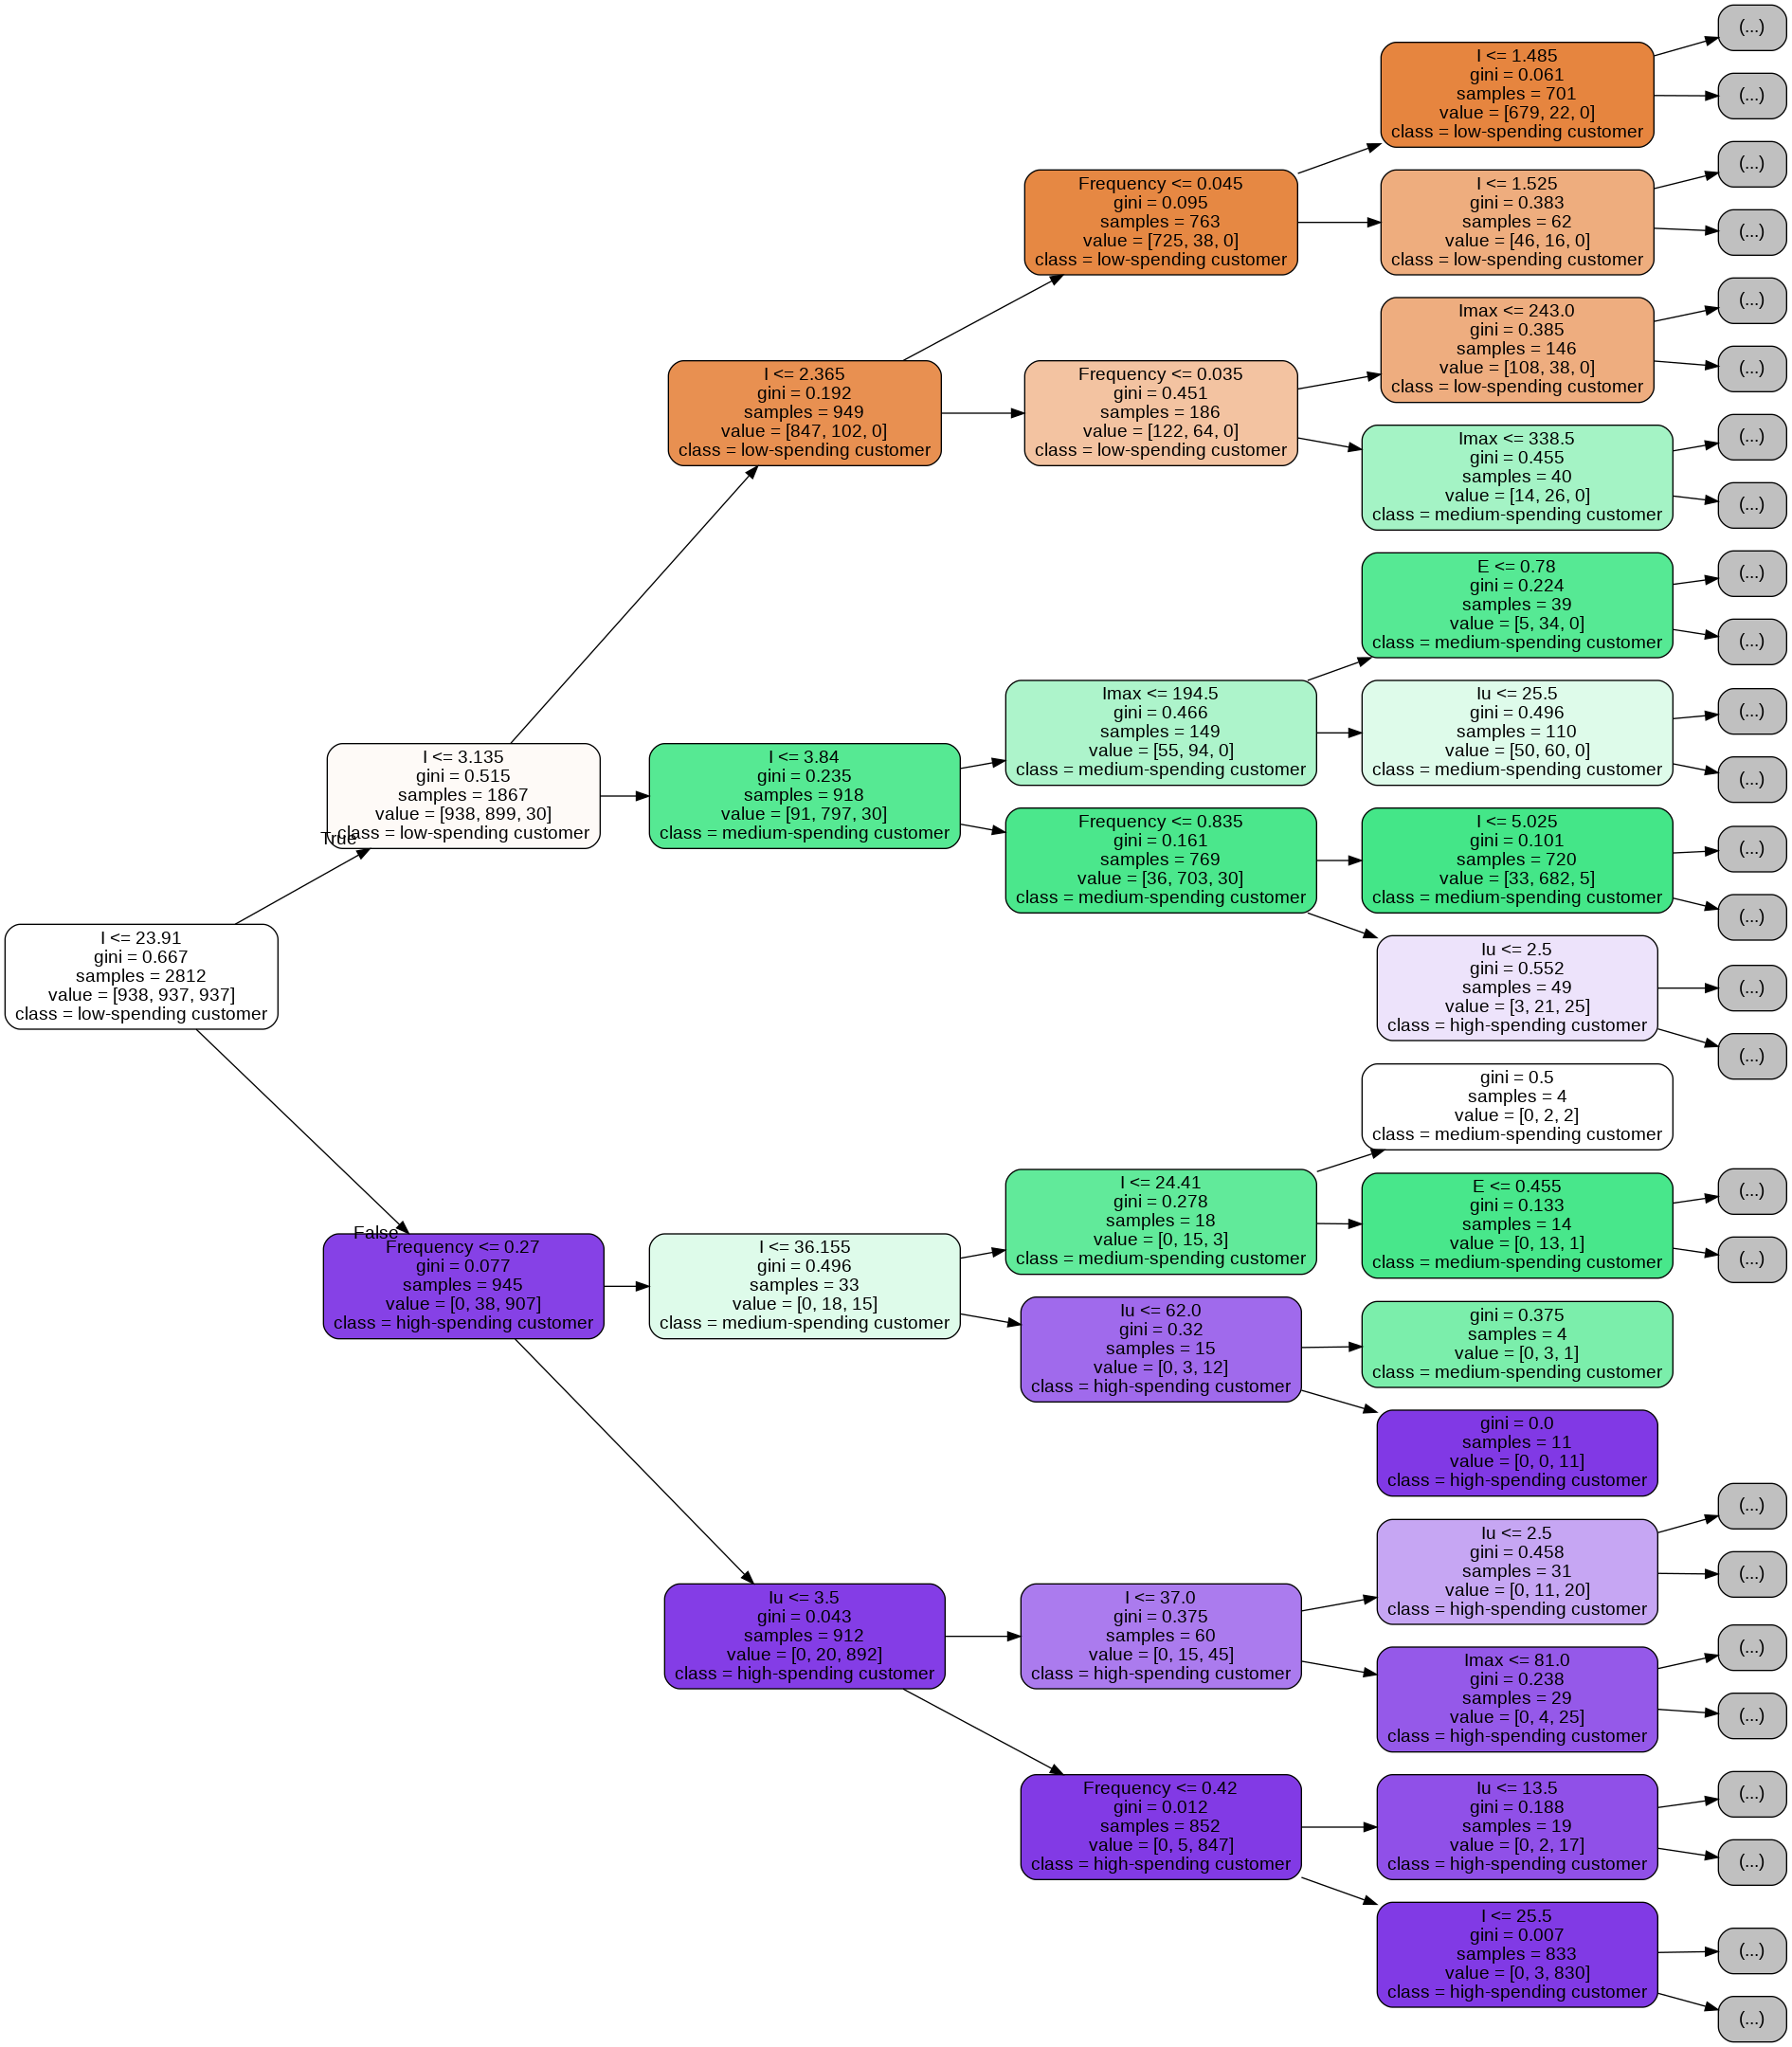

In [ ]:
# visualize the actual decision tree obtained 
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(grid_search_cv.best_estimator_,
               out_file=None,
               max_depth=4, 
               feature_names=list(train_set.columns),  
               class_names=['low-spending customer', 'medium-spending customer', 'high-spending customer'],  
               filled=True,
               rotate=True,
               rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [28]:
ct.keys()

Index(['I', 'Iu', 'Imax', 'Frequency', 'E'], dtype='object')

In [29]:
grid_search_cv.best_estimator_.feature_importances_

array([0.93961115, 0.01584913, 0.00651247, 0.03642502, 0.00160223])

In [30]:
# predict using the decision tree
# the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = grid_search_cv.best_estimator_.predict(train_set)
test_pred_dt = grid_search_cv.best_estimator_.predict(test_set)

Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [31]:
# evaulate the accuracy on the train set and the test set
# metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_dt))

Accuracy train set  0.9270981507823614
Accuracy test set  0.9253731343283582
Precision train set  0.9282642490098919
Precision test set  0.9255940833816817
Recall train set  0.9270981507823614
Recall test set  0.9253731343283582
F1 score train set  0.9273016474269418
F1 score test set  0.9254636854998999
Support train set  (array([0.93064877, 0.87132725, 0.98281418]), array([0.8869936 , 0.91782284, 0.97652081]), array([0.90829694, 0.89397089, 0.97965739]), array([938, 937, 937]))
Support test set  (array([0.92258065, 0.88291139, 0.97115385]), array([0.91373802, 0.89423077, 0.96805112]), array([0.91813804, 0.88853503, 0.9696    ]), array([313, 312, 313]))


In [32]:
# metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['low-spending customer', 'medium-spending customer', 'high-spending customer']))

In [33]:
report_scores(train_label, train_pred_dt)

                          precision    recall  f1-score   support

   low-spending customer       0.93      0.89      0.91       938
medium-spending customer       0.87      0.92      0.89       937
  high-spending customer       0.98      0.98      0.98       937

                accuracy                           0.93      2812
               macro avg       0.93      0.93      0.93      2812
            weighted avg       0.93      0.93      0.93      2812



In [34]:
report_scores(test_label, test_pred_dt)

                          precision    recall  f1-score   support

   low-spending customer       0.92      0.91      0.92       313
medium-spending customer       0.88      0.89      0.89       312
  high-spending customer       0.97      0.97      0.97       313

                accuracy                           0.93       938
               macro avg       0.93      0.93      0.93       938
            weighted avg       0.93      0.93      0.93       938



In [35]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[286,  27,   0],
       [ 24, 279,   9],
       [  0,  10, 303]])

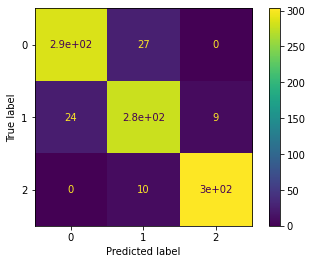

In [36]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(grid_search_cv.best_estimator_, test_set, test_label)
plt.show() 

#### Classification with Random Forest

* Grid search for hyper-parameters of Random Forest :
1. 'n_estimators' : [25, 50 ,100, 200, 500, 1000],
2. 'max_depth': [2,3,5,6,7,10,12,None],
3. 'max_features': sp_randint(1, len(train_set.iloc[0]) + 1),
4. 'min_samples_split': sp_randint(10, 51),
5. 'min_samples_leaf': sp_randint(10, 51),
6. 'bootstrap': [True, False],
7. 'criterion': ["entropy", "gini"],
8. 'class_weight':['balanced', None, {0: 0.2, 1: 0.3, 2: 0.5}, {0: 0.1, 1: 0.1, 2: 0.8}]

Randomized Grid search for parameter setting 

In [ ]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {'n_estimators' : [25, 50 ,100, 200, 500, 1000],
        'max_depth': [2,3,5,6,7,10,12,None],
        'max_features': sp_randint(1, len(train_set.iloc[0]) + 1),
        'min_samples_split': sp_randint(10, 51),
        'min_samples_leaf': sp_randint(10, 51),
        'bootstrap': [True, False],
        'criterion': ["entropy", "gini"],
        'class_weight':['balanced', None, {0: 0.2, 1: 0.3, 2: 0.5}, {0: 0.1, 1: 0.1, 2: 0.8}]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_cv = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=n_iter_search,n_jobs=10,cv=5,verbose=1,scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_cv.fit(train_set, train_label)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   34.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 250 out of 250 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
grid_search_cv.best_params_

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 2,
 'min_samples_leaf': 14,
 'min_samples_split': 39,
 'n_estimators': 1000}

In [ ]:
grid_search_cv.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=14, min_samples_split=39,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
grid_search_cv.best_estimator_.feature_importances_

array([0.54573422, 0.03874158, 0.05319477, 0.26883066, 0.09349878])

In [ ]:
print('Mean and std of this setting ', grid_search_cv.cv_results_['mean_test_score'][0], 
      grid_search_cv.cv_results_['std_test_score'][0])

Mean and std of this setting  0.9057527354095688 0.009943408177068402


In [ ]:
# prediction on the train/test set
train_pred_rf = grid_search_cv.best_estimator_.predict(train_set)
test_pred_rf = grid_search_cv.best_estimator_.predict(test_set)

In [ ]:
# evaulate the accuracy on the train set and the test set
# metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_dt))

Accuracy train set  0.9327880512091038
Accuracy test set  0.908315565031983
Precision train set  0.9324699014190176
Precision test set  0.9077001924463391
Recall train set  0.9327880512091038
Recall test set  0.908315565031983
F1 score train set  0.9325985453750293
F1 score test set  0.9077186473823823
Support train set  (array([0.92258065, 0.90215054, 0.97268908]), array([0.91471215, 0.89541089, 0.98826041]), array([0.91862955, 0.89876808, 0.98041292]), array([938, 937, 937]))
Support test set  (array([0.91      , 0.86495177, 0.94801223]), array([0.87220447, 0.86217949, 0.99041534]), array([0.89070147, 0.8635634 , 0.96875   ]), array([313, 312, 313]))


In [ ]:
# compute the performance of the model
report_scores(train_label, train_pred_dt)

                          precision    recall  f1-score   support

   low-spending customer       0.92      0.91      0.92       938
medium-spending customer       0.90      0.90      0.90       937
  high-spending customer       0.97      0.99      0.98       937

                accuracy                           0.93      2812
               macro avg       0.93      0.93      0.93      2812
            weighted avg       0.93      0.93      0.93      2812



In [ ]:
report_scores(test_label, test_pred_rf)

                          precision    recall  f1-score   support

   low-spending customer       0.89      0.89      0.89       313
medium-spending customer       0.87      0.84      0.86       312
  high-spending customer       0.95      0.99      0.97       313

                accuracy                           0.91       938
               macro avg       0.90      0.91      0.90       938
            weighted avg       0.90      0.91      0.90       938



#### Classification with SVM

* Grid search for hyper-parameters of SVM :
1. 'C': [1.0, 10000.0, 100000.0],
2. 'gamma' : ['scale', 'auto']

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

params = {'C': [1.0, 10000.0, 100000.0],
      'gamma' : ['scale', 'auto']}

grid_search_cv = GridSearchCV(SVC(),params,verbose=1,cv=5)
grid_search_cv.fit(train_set, train_label)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   26.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 10000.0, 100000.0],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
grid_search_cv.best_params_

In [ ]:
grid_search_cv.best_estimator_

SVC(C=10000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# prediction on the train/test set
train_pred_svm = grid_search_cv.best_estimator_.predict(train_set)
test_pred_svm = grid_search_cv.best_estimator_.predict(test_set)

In [ ]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_svm))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_svm))
print('Precision train set ', metrics.precision_score(train_label, train_pred_svm, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_svm, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_svm, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_svm, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_svm, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_svm, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_svm))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_svm))

Accuracy train set  0.9246088193456614
Accuracy test set  0.8997867803837953
Precision train set  0.9247432625924334
Precision test set  0.8986790502406393
Recall train set  0.9246088193456614
Recall test set  0.8997867803837953
F1 score train set  0.9242707212525337
F1 score test set  0.8988981168244773
Support train set  (array([0.88900204, 0.90960452, 0.97566138]), array([0.93070362, 0.85912487, 0.98399146]), array([0.909375  , 0.88364435, 0.97980871]), array([938, 937, 937]))
Support test set  (array([0.88291139, 0.86824324, 0.94478528]), array([0.8913738 , 0.82371795, 0.98402556]), array([0.88712242, 0.84539474, 0.96400626]), array([313, 312, 313]))


In [ ]:
# compute the performance of the model
report_scores(train_label,train_pred_svm)

                          precision    recall  f1-score   support

   low-spending customer       0.89      0.93      0.91       938
medium-spending customer       0.91      0.86      0.88       937
  high-spending customer       0.98      0.98      0.98       937

                accuracy                           0.92      2812
               macro avg       0.92      0.92      0.92      2812
            weighted avg       0.92      0.92      0.92      2812



In [ ]:
report_scores(test_label,test_pred_svm)

                          precision    recall  f1-score   support

   low-spending customer       0.88      0.89      0.89       313
medium-spending customer       0.87      0.82      0.85       312
  high-spending customer       0.94      0.98      0.96       313

                accuracy                           0.90       938
               macro avg       0.90      0.90      0.90       938
            weighted avg       0.90      0.90      0.90       938



#### Classification with rule based 

There are several rule-based methods. One of the most popular is RIPPER. To use it, you have to install it using !pip install wittgenstein. The documentation of this method can be found in https://github.com/imoscovitz/wittgenstein

In [ ]:
!pip install wittgenstein

* Grid search for hyper-parameters of rule based :
1. 'prune_size': [0.5, 0.6, 0.7], 
2. 'k': [1, 3, 5]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from keras.utils import np_utils
import wittgenstein as lw

#we run a grid search to find the best configuration of parameters' values
params = {"estimator__prune_size": [0.5, 0.6, 0.7],
      "estimator__k": [1, 3, 5]}

grid_search_cv = GridSearchCV(OneVsRestClassifier(lw.RIPPER()),params,verbose=1,cv=5)

# convert integers to dummy variables (i.e. one hot encoded)
train_y = np_utils.to_categorical(train_label)
test_y = np_utils.to_categorical(test_label)
grid_search_cv.fit(train_set, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [1, 7, 21, 56, 57, 67, 80, 85, 94, 102, 140, 143, 157, 160, 191, 204, 208, 209, 213, 231, 232, 265, 274, 289, 297, 305, 315, 317, 332, 336, 337, 339, 353, 380, 388, 389, 395, 410, 413, 426, 460, 476, 486, 489, 513, 523, 529, 530, 536, 539]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [2, 25, 30, 38, 49, 52, 58, 59, 63, 71, 73, 89, 93, 103, 113, 115, 123, 141, 165, 167, 168, 169, 182, 186, 187, 201, 216, 226, 264, 281, 284, 311, 326, 341, 351, 375, 440, 444, 483, 490, 491, 501, 544, 553]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False

base.py: .predict_proba: Runtime

GridSearchCV(cv=5, error_score=nan,
             estimator=OneVsRestClassifier(estimator=<RIPPER(prune_size=0.33, max_rules=None, max_total_conds=None, k=2, dl_allowance=64, verbosity=0, max_rule_conds=None, random_state=None, n_discretize_bins=10)>,
                                           n_jobs=None),
             iid='deprecated', n_jobs=None,
             param_grid={'estimator__k': [1, 3, 5],
                         'estimator__prune_size': [0.5, 0.6, 0.7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
grid_search_cv.best_params_

{'estimator__k': 5, 'estimator__prune_size': 0.7}

In [ ]:
grid_search_cv.best_estimator_

OneVsRestClassifier(estimator=<RIPPER(prune_size=0.7, max_rules=None, max_total_conds=None, k=5, dl_allowance=64, verbosity=0, max_rule_conds=None, random_state=None, n_discretize_bins=10)>,
                    n_jobs=None)

In [ ]:
train_pred_RIPPER = grid_search_cv.best_estimator_.predict_proba(train_set)
test_pred_RIPPER = grid_search_cv.best_estimator_.predict_proba(test_set)

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [46, 171, 1119]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [456, 517, 638, 807, 1888, 2663]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [2, 25, 30, 38, 49, 52, 58, 59, 63, 71, 73, 89, 93, 103, 113, 115, 123, 141, 167, 168, 169, 182, 186, 187, 201, 216, 226, 264, 281, 284, 311, 326, 341, 351, 354, 359, 440, 442, 444, 483, 490, 491, 501, 544, 553, 597, 626, 637, 691, 710, 715, 731, 781, 823, 938, 988, 1159, 1170, 1390, 1597, 2036, 2119, 2211, 2348, 2411, 2553]
 Consider running recalibrate_proba with smaller param min_samples

In [ ]:
train_pred_ripper = []
test_pred_ripper = []
for item in train_pred_RIPPER:
  train_pred_ripper.append(numpy.argmax(item))
for item in test_pred_RIPPER:
  test_pred_ripper.append(numpy.argmax(item))

In [ ]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_ripper))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_ripper))
print('Precision train set ', metrics.precision_score(train_label, train_pred_ripper, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_ripper, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_ripper, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_ripper, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_ripper, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_ripper, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_ripper))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_ripper))

Accuracy train set  0.7219061166429588
Accuracy test set  0.7782515991471215
Precision train set  0.764487080113278
Precision test set  0.785577527114641
Recall train set  0.7219061166429588
Recall test set  0.7782515991471215
F1 score train set  0.7206925856321443
F1 score test set  0.7792047504092788
Support train set  (array([0.89114659, 0.79855072, 0.60362875]), array([0.65458422, 0.58804696, 0.92315902]), array([0.75476337, 0.67732022, 0.72995781]), array([938, 937, 937]))
Support test set  (array([0.88644689, 0.74917492, 0.72099448]), array([0.77316294, 0.7275641 , 0.83386581]), array([0.82593857, 0.73821138, 0.77333333]), array([313, 312, 313]))


In [ ]:
# compute the performance of the model
report_scores(train_label,train_pred_ripper)

                          precision    recall  f1-score   support

   low-spending customer       0.89      0.65      0.75       938
medium-spending customer       0.80      0.59      0.68       937
  high-spending customer       0.60      0.92      0.73       937

                accuracy                           0.72      2812
               macro avg       0.76      0.72      0.72      2812
            weighted avg       0.76      0.72      0.72      2812



In [ ]:
report_scores(test_label,test_pred_ripper)

                          precision    recall  f1-score   support

   low-spending customer       0.89      0.77      0.83       313
medium-spending customer       0.75      0.73      0.74       312
  high-spending customer       0.72      0.83      0.77       313

                accuracy                           0.78       938
               macro avg       0.79      0.78      0.78       938
            weighted avg       0.79      0.78      0.78       938



In [ ]:
#in this case the model is a set of rules, retrain a model to get the set of rules
import wittgenstein as lw
ripper = OneVsRestClassifier(lw.RIPPER(k=grid_search_cv.best_params_.get('estimator__k'), prune_size=grid_search_cv.best_params_.get('estimator__prune_size')))
ripper.fit(train_set, train_y)

OneVsRestClassifier(estimator=<RIPPER(prune_size=0.7, max_rules=None, max_total_conds=None, k=5, dl_allowance=64, verbosity=0, max_rule_conds=None, random_state=None, n_discretize_bins=10)>,
                    n_jobs=None)

In [ ]:
ripper.estimators_[0].ruleset_

<Ruleset [I=-162.0-1.01^Frequency=0.01-0.01] V [I=1.01-1.77^Frequency=0.01-0.01] V [Frequency=0.01-0.02^I=-162.0-1.01] V [Frequency=0.01-0.02^I=1.01-1.77^E=0.59-0.69] V [I=1.77-2.69^Frequency=0.01-0.01] V [Frequency=0.01-0.02^I=1.01-1.77] V [I=1.77-2.69^Frequency=0.01-0.02^Imax=180.0-223.0] V [I=1.77-2.69^E=0.59-0.69^Frequency=0.01-0.02] V [I=1.77-2.69] V [I=2.69-3.97^Frequency=0.01-0.01^E=0.59-0.69] V [I=2.69-3.97^Frequency=0.01-0.02^Imax=271.0-351.0^Iu=95.0-164.0] V [Frequency=0.02-0.03^I=1.01-1.77^E=0.59-0.69] V [I=-162.0-1.01] V [I=1.01-1.77^Imax=80.0-110.0] V [I=1.01-1.77^E=0.69-1.01] V [Frequency=0.02-0.03^I=1.01-1.77^E=1.01-1.2] V [I=2.69-3.97^E=0.59-0.69^Iu=26.0-36.0] V [I=1.01-1.77] V [I=2.69-3.97^Iu=36.0-49.0^Imax=223.0-271.0^Frequency=0.03-0.05] V [I=2.69-3.97^E=0.0-0.59^Frequency=0.02-0.03] V [I=2.69-3.97^Imax=110.0-141.0^Iu=67.0-95.0] V [I=2.69-3.97^Imax=180.0-223.0^Iu=18.0-26.0]>

In [ ]:
ripper.estimators_[1].ruleset_

<Ruleset [I=5.95-10.89^Frequency=0.05-0.22] V [I=3.97-5.95] V [I=5.95-10.89^Frequency=0.03-0.05] V [I=10.89-41.0^Frequency=0.05-0.22^Imax=351.0-478.0] V [I=5.95-10.89^E=0.69-1.01] V [I=2.69-3.97^Frequency=0.03-0.05^Iu=164.0-1264.0] V [I=2.69-3.97^Frequency=0.03-0.05^Iu=95.0-164.0] V [I=10.89-41.0^Frequency=0.05-0.22^E=0.59-0.69] V [I=2.69-3.97^Frequency=0.05-0.22] V [I=2.69-3.97^E=1.2-1.48] V [I=10.89-41.0^Frequency=0.05-0.22^E=0.0-0.59] V [I=5.95-10.89^E=1.01-1.2] V [I=5.95-10.89] V [I=10.89-41.0^Imax=478.0-2777.0^E=0.69-1.01] V [I=10.89-41.0^Frequency=0.05-0.22] V [I=2.69-3.97^Frequency=0.03-0.05] V [I=2.69-3.97^Frequency=0.02-0.03^E=1.01-1.2] V [I=10.89-41.0^Frequency=0.03-0.05] V [I=2.69-3.97^Imax=351.0-478.0^Iu=67.0-95.0] V [I=1.77-2.69^Imax=-162.0-48.0] V [I=10.89-41.0^E=0.59-0.69] V [I=2.69-3.97^Imax=180.0-223.0] V [I=10.89-41.0^Imax=110.0-141.0]>

In [ ]:
ripper.estimators_[2].ruleset_

<Ruleset [Frequency=0.22-1.0^I=94.0-184.0] V [Frequency=0.22-1.0^I=184.0-1301.5] V [E=0.0-0.0^I=41.0-94.0^Iu=6.0-11.0] V [Frequency=0.22-1.0^I=41.0-94.0^Imax=48.0-80.0] V [Frequency=0.22-1.0^I=41.0-94.0^E=0.0-0.0] V [Frequency=0.22-1.0^I=10.89-41.0^Imax=-162.0-48.0^Iu=6.0-11.0] V [E=0.0-0.0^I=10.89-41.0^Iu=11.0-18.0] V [E=0.0-0.0^Frequency=1.0-4.0^I=94.0-184.0] V [Frequency=0.22-1.0^I=10.89-41.0^E=0.0-0.0] V [Frequency=1.0-4.0^I=184.0-1301.5] V [Frequency=0.22-1.0^I=41.0-94.0] V [I=10.89-41.0^Frequency=0.22-1.0^Imax=141.0-180.0] V [I=41.0-94.0] V [Frequency=0.22-1.0^Iu=26.0-36.0] V [I=10.89-41.0^Frequency=0.22-1.0^Imax=180.0-223.0] V [I=94.0-184.0] V [Frequency=0.22-1.0^Iu=164.0-1264.0]>

In [ ]:
#with rule based classifiers it is possible to extract the reasons for the prediction.
#only for the positive predictions
ripper.estimators_[0].predict(test_set[:15], give_reasons=True)

([True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False],
 [[<Rule [I=1.77-2.69]>],
  [<Rule [I=-162.0-1.01^Frequency=0.01-0.01]>, <Rule [I=-162.0-1.01]>],
  [<Rule [I=1.77-2.69]>],
  [],
  [],
  [<Rule [Frequency=0.01-0.02^I=1.01-1.77]>, <Rule [I=1.01-1.77]>],
  [],
  [],
  [],
  [],
  [<Rule [I=1.77-2.69]>],
  [],
  [<Rule [Frequency=0.01-0.02^I=-162.0-1.01]>, <Rule [I=-162.0-1.01]>],
  [],
  []])

In [ ]:
#with rule based classifiers it is possible to extract the reasons for the prediction.
#only for the positive predictions
ripper.estimators_[1].predict(test_set[:15], give_reasons=True)

([False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False],
 [[],
  [],
  [],
  [],
  [<Rule [I=3.97-5.95]>],
  [],
  [],
  [<Rule [I=2.69-3.97^E=1.2-1.48]>],
  [<Rule [I=10.89-41.0^Frequency=0.05-0.22^Imax=351.0-478.0]>,
   <Rule [I=10.89-41.0^Frequency=0.05-0.22^E=0.0-0.59]>,
   <Rule [I=10.89-41.0^Frequency=0.05-0.22]>],
  [],
  [],
  [],
  [],
  [],
  []])

In [ ]:
#with rule based classifiers it is possible to extract the reasons for the prediction.
#only for the positive predictions
ripper.estimators_[2].predict(test_set[:15], give_reasons=True)

([False,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True],
 [[],
  [],
  [],
  [<Rule [Frequency=0.22-1.0^I=10.89-41.0^E=0.0-0.0]>],
  [],
  [],
  [<Rule [Frequency=0.22-1.0^I=10.89-41.0^Imax=-162.0-48.0^Iu=6.0-11.0]>,
   <Rule [Frequency=0.22-1.0^I=10.89-41.0^E=0.0-0.0]>],
  [],
  [],
  [],
  [],
  [],
  [],
  [<Rule [E=0.0-0.0^I=41.0-94.0^Iu=6.0-11.0]>,
   <Rule [Frequency=0.22-1.0^I=41.0-94.0^Imax=48.0-80.0]>,
   <Rule [Frequency=0.22-1.0^I=41.0-94.0^E=0.0-0.0]>,
   <Rule [Frequency=0.22-1.0^I=41.0-94.0]>,
   <Rule [I=41.0-94.0]>],
  [<Rule [Frequency=0.22-1.0^I=184.0-1301.5]>]])

#### Normalization for KNN and neural network

In [ ]:
# preprocessing - Normalization 
scaler_m = MinMaxScaler()
ct.loc[:,:] = scaler_m.fit_transform(ct.values)
train_set, test_set, train_label, test_label = train_test_split(ct, label, stratify =label, test_size=0.25)
len(train_set),len(test_set)

(2812, 938)

#### Classification with KNN

* Grid search for hyper-parameters of KNN:
1. 'n_neighbors' : [2, 5, 10, 20]
2. 'weights' : ['uniform', 'distance']

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors' : [2, 5, 10],
      'weights' : ['uniform', 'distance']}

grid_search_cv = GridSearchCV(KNeighborsClassifier(),params,verbose=1,cv=5)
grid_search_cv.fit(train_set, train_label)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 5, 10],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
grid_search_cv.best_params_

In [ ]:
grid_search_cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [ ]:
# prediction on the train/test set
train_pred_knn = grid_search_cv.best_estimator_.predict(train_set)
test_pred_knn = grid_search_cv.best_estimator_.predict(test_set)

In [ ]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_knn))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_knn))
print('Precision train set ', metrics.precision_score(train_label, train_pred_knn, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_knn, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_knn, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_knn, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_knn, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_knn, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_knn))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_knn))

Accuracy train set  0.9967994310099573
Accuracy test set  0.8347547974413646
Precision train set  0.9967994233075506
Precision test set  0.8361524287026441
Recall train set  0.9967994310099573
Recall test set  0.8347547974413646
F1 score train set  0.9967988594872872
F1 score test set  0.8334843418726477
Support train set  (array([0.99893504, 0.99466951, 0.99679144]), array([1.        , 0.99573106, 0.99466382]), array([0.99946723, 0.9952    , 0.9957265 ]), array([938, 937, 937]))
Support test set  (array([0.75213675, 0.79120879, 0.96496815]), array([0.84345048, 0.69230769, 0.96805112]), array([0.79518072, 0.73846154, 0.96650718]), array([313, 312, 313]))


In [ ]:
# compute the performance of the model
report_scores(train_label,train_pred_knn)

                          precision    recall  f1-score   support

   low-spending customer       1.00      1.00      1.00       938
medium-spending customer       0.99      1.00      1.00       937
  high-spending customer       1.00      0.99      1.00       937

                accuracy                           1.00      2812
               macro avg       1.00      1.00      1.00      2812
            weighted avg       1.00      1.00      1.00      2812



In [ ]:
report_scores(test_label,test_pred_knn)

                          precision    recall  f1-score   support

   low-spending customer       0.75      0.84      0.80       313
medium-spending customer       0.79      0.69      0.74       312
  high-spending customer       0.96      0.97      0.97       313

                accuracy                           0.83       938
               macro avg       0.84      0.83      0.83       938
            weighted avg       0.84      0.83      0.83       938



#### Classification with neural network

We define, using keras (under tensorflow), a simple feed forward nn and then we fit it. Note that in this case the nn is a Sequential model, composed of layers. We can add as many layers as we want, but in the first one we need to define the input structure.  

* Grid search for hyper-parameters of Neural network :
1. 'optimizers' : ['Adam', 'Adamax']
2. 'init' : ['normal', 'uniform']
3. 'batches' : [32, 64]

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

def create_model(init='uniform', optimizer='Adam'):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=len(ct.columns), kernel_initializer=init, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(3, kernel_initializer=init, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search init, batch size and optimizer
optimizers = ['Adam', 'Adamax']
init = ['normal', 'uniform']
batches = [32, 64]
param_grid = dict(optimizer=optimizers, batch_size=batches, init=init)
grid_search_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.asarray(train_set).astype('float32').reshape((-1,len(ct.columns)))
# convert integers to dummy variables (i.e. one hot encoded)
train_y = np_utils.to_categorical(train_label)
test_y = np_utils.to_categorical(test_label)

grid_result = grid_search_cv.fit(x_train, train_y, epochs=300, validation_split=0.25)

In [ ]:
grid_search_cv.best_params_

{'batch_size': 32, 'init': 'normal', 'optimizer': 'Adam'}

In [ ]:
# prediction on the train/test set
train_pred_nn = grid_search_cv.best_estimator_.predict(train_set)
test_pred_nn = grid_search_cv.best_estimator_.predict(test_set)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

In [ ]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_nn))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_nn))
print('Precision train set ', metrics.precision_score(train_label, train_pred_nn, average='weighted'))
print('Precision test set ', metrics.precision_score(test_label, test_pred_nn, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_nn, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_nn, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_nn, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_nn, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_nn))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_nn))

Accuracy train set  0.905049786628734
Accuracy test set  0.8976545842217484
Precision train set  0.9060159679556142
Precision test set  0.8969254279821011
Recall train set  0.905049786628734
Recall test set  0.8976545842217484
F1 score train set  0.9049648765385444
F1 score test set  0.8970350507189124
Support train set  (array([0.90742857, 0.83906883, 0.971549  ]), array([0.84648188, 0.88473853, 0.98399146]), array([0.8758963 , 0.8612987 , 0.97773065]), array([938, 937, 937]))
Support test set  (array([0.88628763, 0.84444444, 0.95987654]), array([0.84664537, 0.8525641 , 0.99361022]), array([0.86601307, 0.84848485, 0.97645212]), array([313, 312, 313]))


In [ ]:
# compute the performance of the model
report_scores(train_label,train_pred_nn)

                          precision    recall  f1-score   support

   low-spending customer       0.91      0.85      0.88       938
medium-spending customer       0.84      0.88      0.86       937
  high-spending customer       0.97      0.98      0.98       937

                accuracy                           0.91      2812
               macro avg       0.91      0.91      0.90      2812
            weighted avg       0.91      0.91      0.90      2812



In [ ]:
report_scores(test_label,test_pred_nn)

                          precision    recall  f1-score   support

   low-spending customer       0.89      0.85      0.87       313
medium-spending customer       0.84      0.85      0.85       312
  high-spending customer       0.96      0.99      0.98       313

                accuracy                           0.90       938
               macro avg       0.90      0.90      0.90       938
            weighted avg       0.90      0.90      0.90       938



In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.902915 using {'batch_size': 32, 'init': 'normal', 'optimizer': 'Adam'}
0.902915 (0.003526) with: {'batch_size': 32, 'init': 'normal', 'optimizer': 'Adam'}
0.888332 (0.014615) with: {'batch_size': 32, 'init': 'normal', 'optimizer': 'Adamax'}
0.899712 (0.010080) with: {'batch_size': 32, 'init': 'uniform', 'optimizer': 'Adam'}
0.891181 (0.000824) with: {'batch_size': 32, 'init': 'uniform', 'optimizer': 'Adamax'}
0.883707 (0.011475) with: {'batch_size': 64, 'init': 'normal', 'optimizer': 'Adam'}
0.895803 (0.003330) with: {'batch_size': 64, 'init': 'normal', 'optimizer': 'Adamax'}
0.870200 (0.006752) with: {'batch_size': 64, 'init': 'uniform', 'optimizer': 'Adam'}
0.885486 (0.010147) with: {'batch_size': 64, 'init': 'uniform', 'optimizer': 'Adamax'}


In [ ]:
# retrain a nn model to check the history
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, len(ct.columns))),
  tf.keras.layers.Dense(64, kernel_initializer=grid_search_cv.best_params_['init'], activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, kernel_initializer=grid_search_cv.best_params_['init'], activation='relu'),
  tf.keras.layers.Dense(3, kernel_initializer=grid_search_cv.best_params_['init'], activation='softmax')
])
model.compile(optimizer=grid_search_cv.best_params_['optimizer'],
              loss='categorical_crossentropy',
              metrics=['accuracy'])

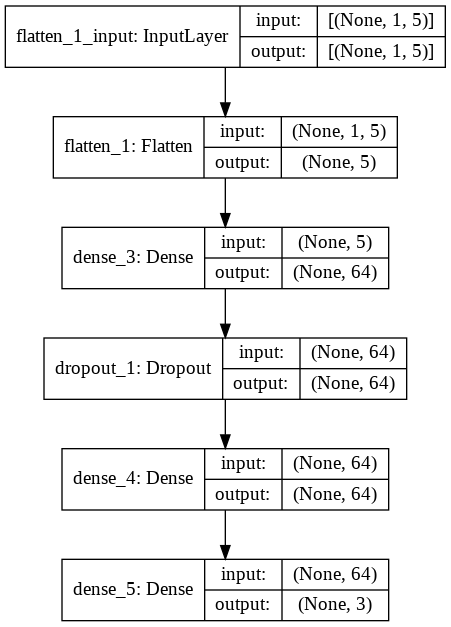

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.utils import np_utils

y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.asarray(train_set).astype('float32').reshape((-1,len(ct.columns)))
# convert integers to dummy variables (i.e. one hot encoded)
train_y = np_utils.to_categorical(train_label)
test_y = np_utils.to_categorical(test_label)
history = model.fit(x_train, train_y,
                    epochs=500,
                    batch_size=grid_search_cv.best_params_['batch_size'],
                    validation_split=0.25)

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 1.0763 - accuracy: 0.5992 - val_loss: 0.8490 - val_accuracy: 0.6131
Epoch 2/500
66/66 [==============================] - 0s 2ms/step - loss: 0.7564 - accuracy: 0.6175 - val_loss: 0.6235 - val_accuracy: 0.6131
Epoch 3/500
66/66 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.6583 - val_loss: 0.6007 - val_accuracy: 0.6458
Epoch 4/500
66/66 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.6641 - val_loss: 0.5863 - val_accuracy: 0.7127
Epoch 5/500
66/66 [==============================] - 0s 2ms/step - loss: 0.6063 - accuracy: 0.6976 - val_loss: 0.5686 - val_accuracy: 0.7326
Epoch 6/500
66/66 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.7076 - val_loss: 0.5497 - val_accuracy: 0.7553
Epoch 7/500
66/66 [==============================] - 0s 2ms/step - loss: 0.5708 - accuracy: 0.7412 - val_loss: 0.5232 - val_accuracy: 0.7710
Epoch 8/500
6

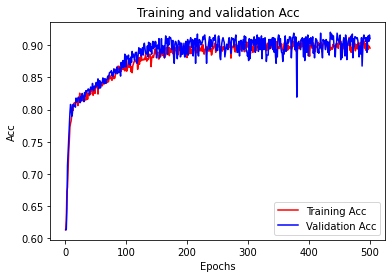

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()